# Baseline model
Predict the rating based on title's length, comment's length, number of days between the transaction date and date of review

## Required librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from time import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

# import python script with customised plotting functions
from plot_metrics import plot_metrics_and_time, plot_radar_metrics, plot_radar_mult
from plot_metrics import plot_radar_some, barplot_metric_mult, lineplot_metrics, stack_barplot

## Load reviews data

In [2]:
df = pd.read_csv("redoute_v3.csv", index_col = 0).reset_index().drop("id", axis = 1)
df.head(1)

,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,month_of_cmt,...,year_of_transaction,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review
0,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,10,...,2023,9,23,5,1,2023-09-23,1049,6.955593,7,12.0


In [3]:
# Prepare the data for a classification model to predicts the rating from comment_lenght, title_length and nb_days_before_review
features = df[["comment_length", "title_length", "nb_days_before_review"]]
#data.head()

# A rating is called a positive rating if it is >= 4 we then set sentiment_r = 1
# A rating is called a negative rating if it is <= 3 we then set sentiment_r = 0
target = 1*(df["rating"]>=4) 
df["sentiment_r"] = target


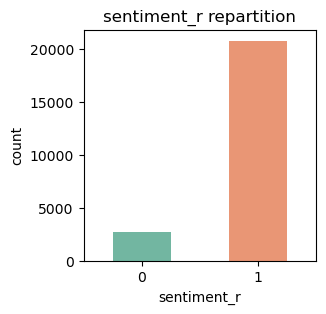

In [4]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x="sentiment_r", width=0.5, palette = "Set2")
plt.title("sentiment_r repartition")
plt.show()

## Train, test and split

Binary classification with sentiment_r as target

In [5]:
# Split data into train data and test data with test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify = target, random_state = 23)


## Preprocessing
- Random Undersampling to tackle imabalance in the classes
- Standard scaling
- MinMax scaling

In [6]:
def scale_data(Xtr,Xts, ytr, scaler="standard"):
    """Scaling of features and Random under sampling on train data 
       with  StandScaler if scaler ="standard", MinMaxScaler if scaler = "minmax"
    """

    if scaler=="standard":
        #standard scaling
        scaler = StandardScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xts_scaled = scaler.transform(Xts)
        
    elif scaler =="minmax":
        scaler = MinMaxScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xts_scaled = scaler.transform(Xts)
        
    else:
        raise ValueError("scaler must be strings: 'standard' or 'minmax'")

    #random undersampling
    ru = RandomUnderSampler()
    (X_ru, y_ru) = ru.fit_resample(Xtr_scaled, ytr)
    
    return Xtr_scaled, Xts_scaled, X_ru, y_ru

#Standard scaled data
X_train_s, X_test_s, X_ru_s, y_ru_s = scale_data(X_train, X_test, y_train)

# With MinMax scaled data
X_train_m, X_test_m, X_ru_m, y_ru_m = scale_data(X_train, X_test, y_train, "minmax")


#control
#print(X_train_s.mean(), X_train_s.std(), X_test_s.mean(), X_test_s.std())
#print(X_train_m.min(), X_train_m.max(), X_test_m.min(), X_test_m.max())


##  Binary Classification
The objective is to predict wether the rating is positive (1) or negative (0)
- Positive rating: rating >= 4
- Negative rating: rating <= 3

###  Function to train and evaluate the model

In [7]:
def fit_and_evaluate(model_name, model, Xru, yru, Xtest, ytest):
    """ function to fit a model and calculate its metrics and time performance
        return a DataFrame of model metrics, model time performance, confusion matrix
        and classification report
    """
    # Fit the model to the training random undersampled data
    t0 = time()
    model.fit(Xru, yru)
    t1 = time()

    # Prediction on test data
    prediction = model.predict(Xtest) 
    t2 = time()
    
    # get durations of processes
    time_train = t1-t0
    time_predict = t2-t1

    # get the model metrics
    accuracy = model.score(Xtest, ytest)

    # The balanced accuracy in binary and multiclass classification problems 
    # to deal with imbalanced datasets.
    # It is defined as the average of recall obtained on each class.
    # The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy = metrics.balanced_accuracy_score(ytest, prediction)
    
    f1_score = metrics.f1_score(ytest, prediction)

    # for the recall we set pos_label=0 to track the ability of the model to capture all negatives rating (rating <=3)
    recall = metrics.recall_score(ytest, prediction, pos_label=0)
    recall_macro = metrics.recall_score(ytest, prediction, average="macro")
    recall_weighted = metrics.recall_score(ytest, prediction, average="weighted")

    f1_score_macro = metrics.f1_score(ytest, prediction, average="macro")
    f1_score_weighted = metrics.f1_score(ytest, prediction, average="weighted")
    
    # precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    # we set pos_label=0
    precision = metrics.precision_score(ytest, prediction, pos_label=0)
    precision_macro = metrics.precision_score(ytest, prediction, average="macro" )
    precision_weighted = metrics.precision_score(ytest, prediction, average="weighted")
    
    cl_report = metrics.classification_report(ytest, prediction)
    cf_matrix = pd.crosstab(ytest, prediction, rownames = ["Real"], colnames=["Prediction"])
    
    # time and metrics
    res = {"model": model_name, 
           "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, 
           "f1": f1_score, "f1_macro": f1_score_macro, "f1_weighted": f1_score_weighted,
           "recall_0": recall, "recall_macro": recall_macro, "recall_weighted": recall_weighted,
           "precision_0" : precision, "precision_macro" : precision_macro, "precision_weighted" : precision_weighted,
           "time_train":time_train, "time_predict": time_predict}
    
    df_metrics = pd.DataFrame(res, index=[0])

    return (df_metrics, cl_report, cf_matrix)

### Models to test

In [8]:
# Models tested
log_reg = LogisticRegression()
dec_tree = DecisionTreeClassifier()
r_fo = RandomForestClassifier()

lsvc = LinearSVC()
svc = SVC()

m_nb = MultinomialNB()  # ne marche pas si valeurs négatives dans les features
c_nb = ComplementNB()
g_nb = GaussianNB()

knn = KNeighborsClassifier()
gdb = GradientBoostingClassifier()


### Fit and evaluate models

In [9]:
# Fit and evaluate models

# Logistic regression
log_reg_metrics, log_reg_cl_report, log_reg_cf_matrix = fit_and_evaluate("log_reg", log_reg, 
                                                                         X_ru_s, y_ru_s, 
                                                                         X_test_s, y_test)

# Decision Tree
dec_tree_metrics, dec_tree_cl_report, dec_tree_cf_matrix = fit_and_evaluate("dec_tree", dec_tree, 
                                                                            X_ru_s, y_ru_s, 
                                                                            X_test_s, y_test)

# Random forest  on standard scaled data
r_fo_metrics, r_fo_cl_report, r_fo_cf_matrix = fit_and_evaluate("r_fo", r_fo, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# Gaussian NB
g_nb_metrics, g_nb_cl_report, g_nb_cf_matrix = fit_and_evaluate("g_nb", g_nb, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# Multinomial NB on minmax scaled data
m_nb_metrics, m_nb_cl_report, m_nb_cf_matrix = fit_and_evaluate("m_nb", m_nb, 
                                                                X_ru_m, y_ru_m, 
                                                                X_test_m, y_test)

# Complement NB on minmax scaled data
c_nb_metrics, c_nb_cl_report, c_nb_cf_matrix = fit_and_evaluate("c_nb", c_nb, 
                                                                X_ru_m, y_ru_m, 
                                                                X_test_m, y_test)

#Linear SVC
lsvc_metrics, lsvc_cl_report, lsvc_cf_matrix = fit_and_evaluate("lsvc", lsvc, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# SVM
svc_metrics, svc_cl_report, svc_cf_matrix = fit_and_evaluate("svc", svc, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)

# KNeighborsClassifier
knn_metrics, knn_cl_report, knn_cf_matrix = fit_and_evaluate("knn", knn, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)

# Gradient Boosting
gdb_metrics, gdb_cl_report, gdb_cf_matrix = fit_and_evaluate("gdb", gdb, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)


## Visualize and compare models performance

### Prepare and save data for visualization

In [10]:
# Put all the models metrics in list
metrics_list = [log_reg_metrics, dec_tree_metrics, r_fo_metrics, 
                g_nb_metrics, m_nb_metrics, c_nb_metrics, 
                lsvc_metrics, svc_metrics,  
                knn_metrics, gdb_metrics]

# concat models metrics into a single data frame
df_m = pd.concat(metrics_list).reset_index().drop("index", axis=1)

# Save metrics into a csv_file
df_temp=df_m.copy()

# add _bsl to model's name to signal a baseline model performance
df_temp["model"] = df_temp["model"]+"_bsl"
df_temp.to_csv("baseline_perf.csv")
del df_temp

### Datavisualization

In [11]:
# Comparison of metrics scores
data = df_m.iloc[:,:-2]  # to skip time_train and time_predict
plot_radar_mult(data)

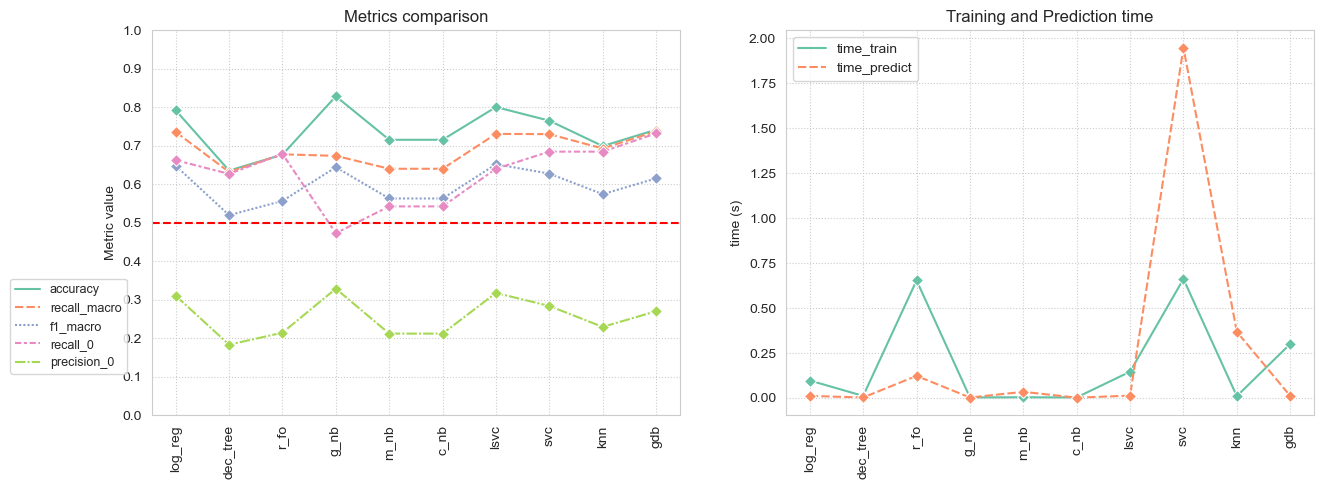

In [12]:
# Compare metrics and time to train and time to predict
plot_metrics_and_time(df_m)

In [13]:
# Line plots of metrics for comparison
lineplot_metrics(data)

In [14]:
# train performance
barplot_metric_mult(df_m, "time_train")
barplot_metric_mult(df_m, "time_predict")

In [15]:
# Comparaison of Accuracy, recall_macro, precision_macro, recall_0, precision_0
for metric in ["accuracy", "recall_macro", "precision_macro", "recall_0", "precision_0"]:
    barplot_metric_mult(data, metric)

In [16]:
# Compare time_train and time_prodict 
stack_barplot(df_m, "time_train", "time_predict")

In [17]:
# Compare recall_macro and precision_macro
stack_barplot(df_m, "recall_macro", "precision_macro")

### Remarks
The precision for label 0 (negative ratings: 1, 2,3 ) for all the models is low with a value between 0.19 and 0.34. At least two third of predicted negatives rating are in fact positive ratings. That is two third of false positives.

The models f1_macro are all superior 0.5 and over 0.6 for the best performing ones.

The best performing model with respect to precision and recall for negative rating, f1-macro and recall macro are :
- - Logistric Regression
  - LinearSVC
  - SVC
  - Gradient Boosting

SVC model is the most time consuming in training and prediction followed by Random Forest model



In [18]:
# Display Classification reports and Confusion Matrix

print("********** log reg **********")
print(log_reg_cl_report)
display(log_reg_cf_matrix)

print("********** Dec Tree **********")
print(dec_tree_cl_report)
display(dec_tree_cf_matrix)

print("********** Random Forest **********")
print(r_fo_cl_report)
display(r_fo_cf_matrix)

print("********** G NB **********")
print( g_nb_cl_report)
display( g_nb_cf_matrix)

print("********** Multinomial NB **********")
print(m_nb_cl_report)
display(m_nb_cf_matrix)

print("********** Complement NB **********")
print(c_nb_cl_report)
display(c_nb_cf_matrix)

print("********** LinearSVC **********")
print(lsvc_cl_report)
display(lsvc_cf_matrix)

print("********** SVC **********")
print(svc_cl_report)
display(svc_cf_matrix)

print("********** KNN **********")
print(knn_cl_report)
display(knn_cf_matrix)

print("********** Gradient Boost **********")
print(gdb_cl_report)
display(gdb_cf_matrix)


********** log reg **********
              precision    recall  f1-score   support

           0       0.31      0.66      0.42       675
           1       0.95      0.81      0.87      5193

    accuracy                           0.79      5868
   macro avg       0.63      0.74      0.65      5868
weighted avg       0.88      0.79      0.82      5868



Prediction,0,1
Real,,
0,447,228
1,994,4199


********** Dec Tree **********
              precision    recall  f1-score   support

           0       0.18      0.63      0.28       675
           1       0.93      0.64      0.76      5193

    accuracy                           0.64      5868
   macro avg       0.56      0.63      0.52      5868
weighted avg       0.84      0.64      0.70      5868



Prediction,0,1
Real,,
0,423,252
1,1888,3305


********** Random Forest **********
              precision    recall  f1-score   support

           0       0.21      0.68      0.33       675
           1       0.94      0.68      0.79      5193

    accuracy                           0.68      5868
   macro avg       0.58      0.68      0.56      5868
weighted avg       0.86      0.68      0.73      5868



Prediction,0,1
Real,,
0,458,217
1,1680,3513


********** G NB **********
              precision    recall  f1-score   support

           0       0.33      0.47      0.39       675
           1       0.93      0.87      0.90      5193

    accuracy                           0.83      5868
   macro avg       0.63      0.67      0.64      5868
weighted avg       0.86      0.83      0.84      5868



Prediction,0,1
Real,,
0,319,356
1,652,4541


********** Multinomial NB **********
              precision    recall  f1-score   support

           0       0.21      0.54      0.30       675
           1       0.93      0.74      0.82      5193

    accuracy                           0.72      5868
   macro avg       0.57      0.64      0.56      5868
weighted avg       0.84      0.72      0.76      5868



Prediction,0,1
Real,,
0,366,309
1,1362,3831


********** Complement NB **********
              precision    recall  f1-score   support

           0       0.21      0.54      0.30       675
           1       0.93      0.74      0.82      5193

    accuracy                           0.72      5868
   macro avg       0.57      0.64      0.56      5868
weighted avg       0.84      0.72      0.76      5868



Prediction,0,1
Real,,
0,366,309
1,1362,3831


********** LinearSVC **********
              precision    recall  f1-score   support

           0       0.32      0.64      0.42       675
           1       0.95      0.82      0.88      5193

    accuracy                           0.80      5868
   macro avg       0.63      0.73      0.65      5868
weighted avg       0.87      0.80      0.83      5868



Prediction,0,1
Real,,
0,432,243
1,929,4264


********** SVC **********
              precision    recall  f1-score   support

           0       0.28      0.68      0.40       675
           1       0.95      0.78      0.85      5193

    accuracy                           0.76      5868
   macro avg       0.62      0.73      0.63      5868
weighted avg       0.87      0.76      0.80      5868



Prediction,0,1
Real,,
0,462,213
1,1167,4026


********** KNN **********
              precision    recall  f1-score   support

           0       0.23      0.68      0.34       675
           1       0.94      0.70      0.80      5193

    accuracy                           0.70      5868
   macro avg       0.59      0.69      0.57      5868
weighted avg       0.86      0.70      0.75      5868



Prediction,0,1
Real,,
0,462,213
1,1554,3639


********** Gradient Boost **********
              precision    recall  f1-score   support

           0       0.27      0.73      0.39       675
           1       0.96      0.74      0.84      5193

    accuracy                           0.74      5868
   macro avg       0.61      0.74      0.62      5868
weighted avg       0.88      0.74      0.78      5868



Prediction,0,1
Real,,
0,494,181
1,1336,3857


##  Optimization with GridSearchCV

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,grid_log_reg,0.791752,0.735405,0.872973,0.647734,0.821154,0.662222,0.735405,0.791752,0.310201,0.62935,0.875074,1.140485,0.00025


LogisticRegression(C=1)
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


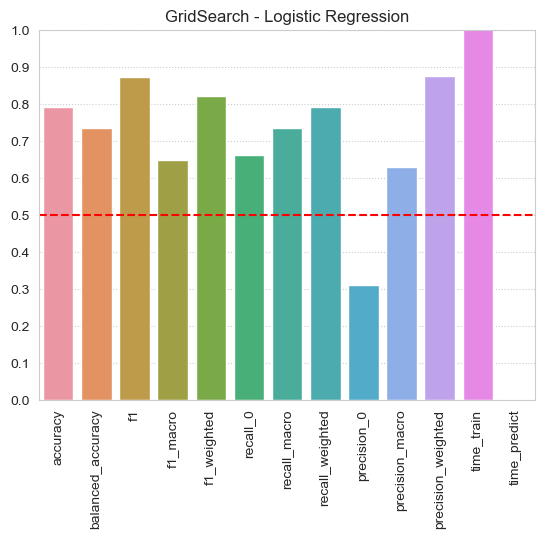

              precision    recall  f1-score   support

           0       0.31      0.66      0.42       675
           1       0.95      0.81      0.87      5193

    accuracy                           0.79      5868
   macro avg       0.63      0.74      0.65      5868
weighted avg       0.88      0.79      0.82      5868



Prediction,0,1
Real,,
0,447,228
1,994,4199


In [19]:
# GridSearchCV on LogisticRegression
log_reg = LogisticRegression()

# parameters
params = {"solver": ["lbfgs", "linear", "newton_cg", "sag"], "penalty": ["l2"], "C": [0.001, 0.1, 1, 5, 10, 100]}
#params = {"solver": ["saga"], "penalty": ["elasticnet", "l1", "l2"], "C": [0.001, 0.01, 0.09, 0.1, 0.11, 0.15]}

# GridSearchCV
grid_log_reg = GridSearchCV(estimator=log_reg, param_grid=params, cv=5)

# fit and evaluate
grid_log_reg_metrics, grid_log_reg_cl_report, grid_log_reg_cf_matrix = fit_and_evaluate("grid_log_reg", grid_log_reg, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_log_reg_metrics)
print(grid_log_reg.best_estimator_)
print(grid_log_reg.best_params_)

# Display metrics
sns.barplot(data=grid_log_reg_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - Logistic Regression")
plt.show()
print(grid_log_reg_cl_report)
display(grid_log_reg_cf_matrix)


#### Remarks
Performance identical to the default LogisticRegression performance

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,grid_lsvc,0.760395,0.731867,0.850298,0.625234,0.79852,0.694815,0.731867,0.760395,0.281007,0.615974,0.873878,0.997787,0.000341


LinearSVC(C=0.0001)
{'C': 0.0001, 'penalty': 'l2'}


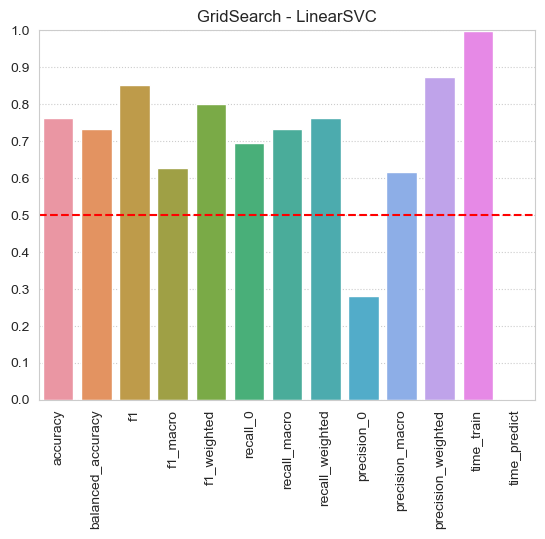

              precision    recall  f1-score   support

           0       0.28      0.69      0.40       675
           1       0.95      0.77      0.85      5193

    accuracy                           0.76      5868
   macro avg       0.62      0.73      0.63      5868
weighted avg       0.87      0.76      0.80      5868



Prediction,0,1
Real,,
0,469,206
1,1200,3993


In [20]:
#GridSearchCV on LinearSVC
lsvc = LinearSVC()

# parameters
params = {"penalty": ["l2"], "C": [1e-7, 1e-6, 1e-5, 1e-4, 0.1, 1]}


# GridSearchCV
grid_lsvc = GridSearchCV(estimator=lsvc, param_grid=params, cv=5)

# fit and evaluate
grid_lsvc_metrics, grid_lsvc_cl_report, grid_lsvc_cf_matrix = fit_and_evaluate("grid_lsvc", grid_lsvc, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_lsvc_metrics)
print(grid_lsvc.best_estimator_)
print(grid_lsvc.best_params_)

# Display metrics
sns.barplot(data=grid_lsvc_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - LinearSVC")
plt.show()
print(grid_lsvc_cl_report)
display(grid_lsvc_cf_matrix)

#### Remarks
Slight improvement of the recall_0 (from 0.65 to 0.70) at the expense of overall accury (from 0.79 to 0.75) 

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,grid_svc,0.797035,0.730012,0.876925,0.649244,0.824544,0.642963,0.730012,0.797035,0.313584,0.629919,0.873477,71.858773,0.409176


SVC(C=10, kernel='linear')
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


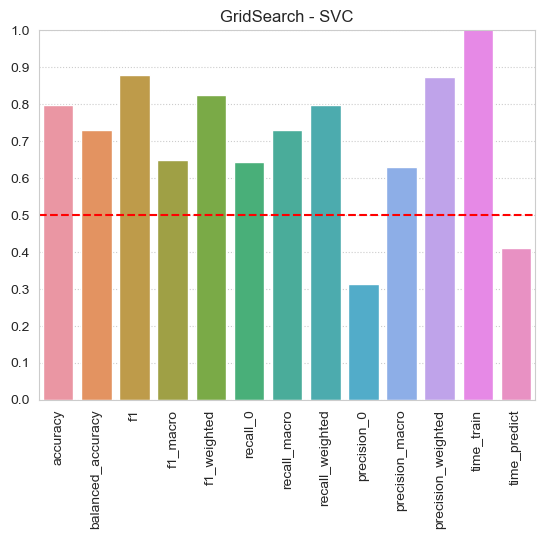

              precision    recall  f1-score   support

           0       0.31      0.64      0.42       675
           1       0.95      0.82      0.88      5193

    accuracy                           0.80      5868
   macro avg       0.63      0.73      0.65      5868
weighted avg       0.87      0.80      0.82      5868



Prediction,0,1
Real,,
0,434,241
1,950,4243


In [21]:
#GridSearch SVC

params = {"kernel": ['linear'],
          "C":[0.001, 0.01, 0.5, 1, 10],
          "gamma": ['scale', 'auto', 0.001, 0.02, 0.05, 0.5]}

svc = SVC()

grid_svc = GridSearchCV(estimator=svc, param_grid=params, cv=5)

grid_svc_metrics, grid_svc_cl_report, grid_svc_cf_matrix = fit_and_evaluate("grid_svc", grid_svc, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_svc_metrics)
print(grid_svc.best_estimator_)
print(grid_svc.best_params_)

# Display metrics
sns.barplot(data=grid_svc_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - SVC")
plt.show()
print(grid_svc_cl_report)
display(grid_svc_cf_matrix)

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,grid_gdb,0.760225,0.736282,0.849952,0.626756,0.798603,0.705185,0.736282,0.760225,0.28266,0.617549,0.875393,80.726011,0.006668


GradientBoostingClassifier(max_depth=1, n_estimators=200)
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}


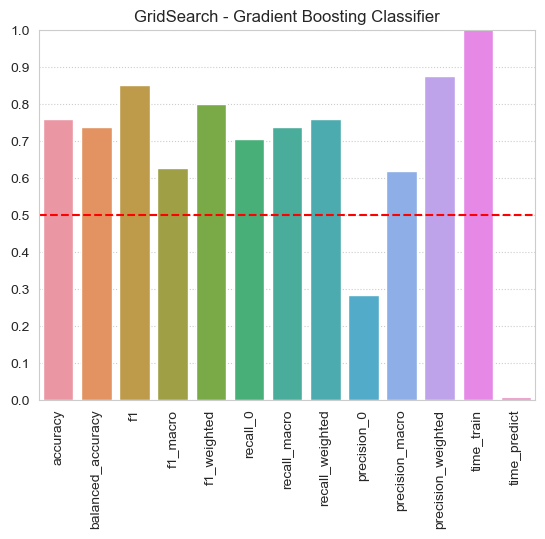

              precision    recall  f1-score   support

           0       0.28      0.71      0.40       675
           1       0.95      0.77      0.85      5193

    accuracy                           0.76      5868
   macro avg       0.62      0.74      0.63      5868
weighted avg       0.88      0.76      0.80      5868



Prediction,0,1
Real,,
0,476,199
1,1208,3985


In [22]:
# GridSearch - Gradient Boosting

params = {'n_estimators':[100, 150, 200], 'max_depth':[1, 2, 3, 4], 'learning_rate':[ 0.01, 0.1, 1, 10]}

gdb = GradientBoostingClassifier()

grid_gdb = GridSearchCV(estimator=gdb, param_grid=params, cv=5)

grid_gdb_metrics, grid_gdb_cl_report, grid_gdb_cf_matrix = fit_and_evaluate("grid_gdb", grid_gdb, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_gdb_metrics)
print(grid_gdb.best_estimator_)
print(grid_gdb.best_params_)

# Display metrics
sns.barplot(data=grid_gdb_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - Gradient Boosting Classifier")
plt.show()
print(grid_gdb_cl_report)
display(grid_gdb_cf_matrix)

####  Visualization Models versus GridSearchCV results

In [23]:
# Concat gridsearch metrics in a single dataFrame
#grid_metrics_list = [grid_log_reg_metrics, log_reg_metrics, 
                    # grid_lsvc_metrics, lsvc_metrics, 
                    # grid_svc_metrics, svc_metrics,  
                    # grid_gdb_metrics, gdb_metrics]

grid_metrics_list = [grid_log_reg_metrics, 
                     grid_lsvc_metrics, 
                     grid_svc_metrics,  
                     grid_gdb_metrics]

df_grid_m = pd.concat(grid_metrics_list).reset_index().drop("index", axis=1)
df_grid_m

# Save metrics into a csv_file
df_temp=df_grid_m.copy()

# add _bsl_grid to model's name to signal a baseline model performance...
# ... after a GridSearchCV
df_temp["model"] = df_temp["model"]+"_bsl_grid"
df_temp.to_csv("bsl_grid_perf.csv")
del df_temp

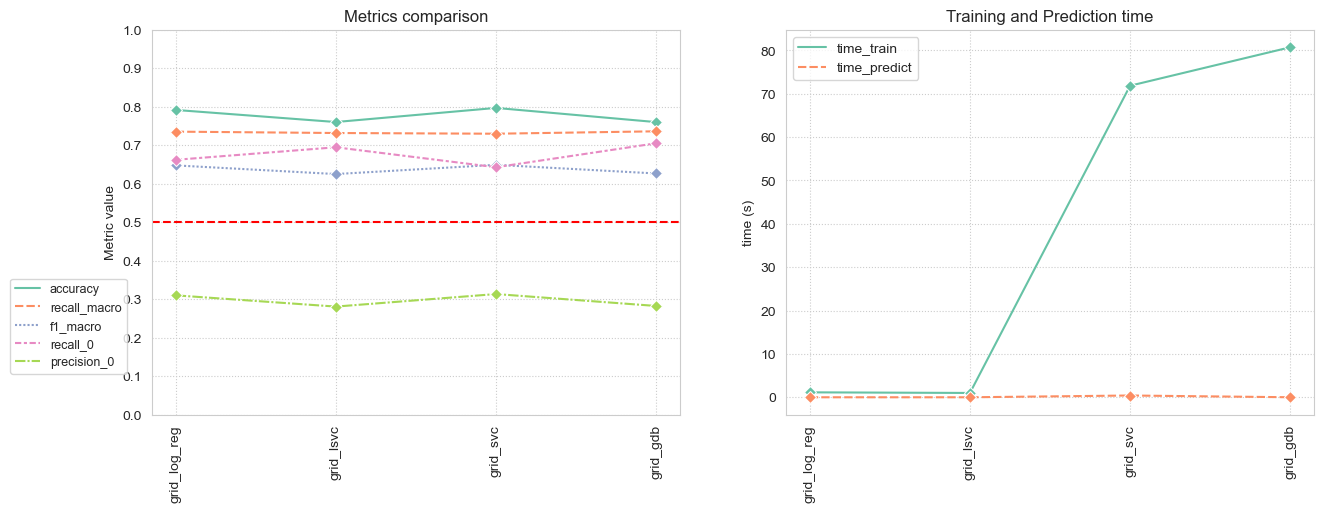

In [24]:
# Visualize and compare models vers GridSearch result
data = df_grid_m.iloc[:,:-2]
plot_radar_mult(data)

# Line plot of models performance
plot_metrics_and_time(df_grid_m)

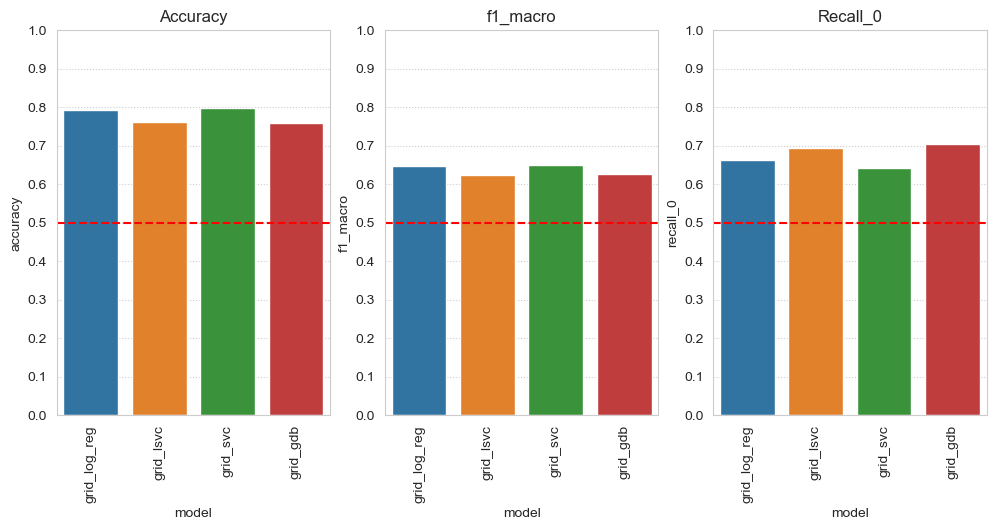

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.barplot(data = df_grid_m[["model", "accuracy"]], y="accuracy", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("Accuracy")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.barplot(data = df_grid_m[["model", "f1_macro"]], y="f1_macro", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("f1_macro")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.barplot(data = df_grid_m[["model", "recall_0"]], y="recall_0", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("Recall_0")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.show()

In [26]:
#time_train	time_predict	accuracy	balanced_accuracy	f1	f1_macro	f1_weighted	recall_0	recall_macro	recall_weighted	precision_0	precision_macro	precision_weighted
col_m =["accuracy", "f1_macro", "precision_macro", "recall_0", "precision_0"]
data = df_grid_m.set_index("model")[col_m].T


In [27]:
#ig = px.bar(df, y='pop', x='country', text_auto='.2s',
#            title="Default: various text sizes, positions and angles")

px.bar(df_grid_m, x = "model", y = "accuracy", text_auto='.2f')

In [28]:
models = ["log_reg", "lsvc", "svc", "gdb"]
data = df_grid_m.iloc[:,:-2]
plot_radar_mult(data)


### Zoom of some models

In [29]:
data = df_m.iloc[:,:-2]
plot_radar_mult(data)

In [30]:
plot_radar_metrics(log_reg_metrics, "Logistic Regression")
plot_radar_metrics(lsvc_metrics, "LinearSVC")
plot_radar_metrics(gdb_metrics, "Gradient Boost")

In [31]:
data = df_m.set_index("model")[col_m].T
fig = px.line(data, markers=True, title="Models Metrics comparison")
fig.update_yaxes(tick0=0, dtick=0.1)
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
fig.show()

## Conclusion
- Although basic, classic classification models applied to title's length, comment's length, and to the number of days between review date and transaction date allow us to pedict the rating sentiment (good rating >=4, Bad rating <=3) with a f1 macro score over  60% for our 4 best models.
- Models performance with these features are not high, but clearly better than random choice, with accuray over 74% and f1 score macro (which capture the high imbalance of the data) over 61%.
- The best performing model with respect to precision and recall for negative rating, f1 macro and recall macro are :
- - Logistric Regression
  - LinearSVC
  - SVC
  - Gradient Boosting
- The three best performing models are able to capture correctly at least 65% of negative rating.
- The overall precision is very poor less than 33% : That is more dans 67% of false positives